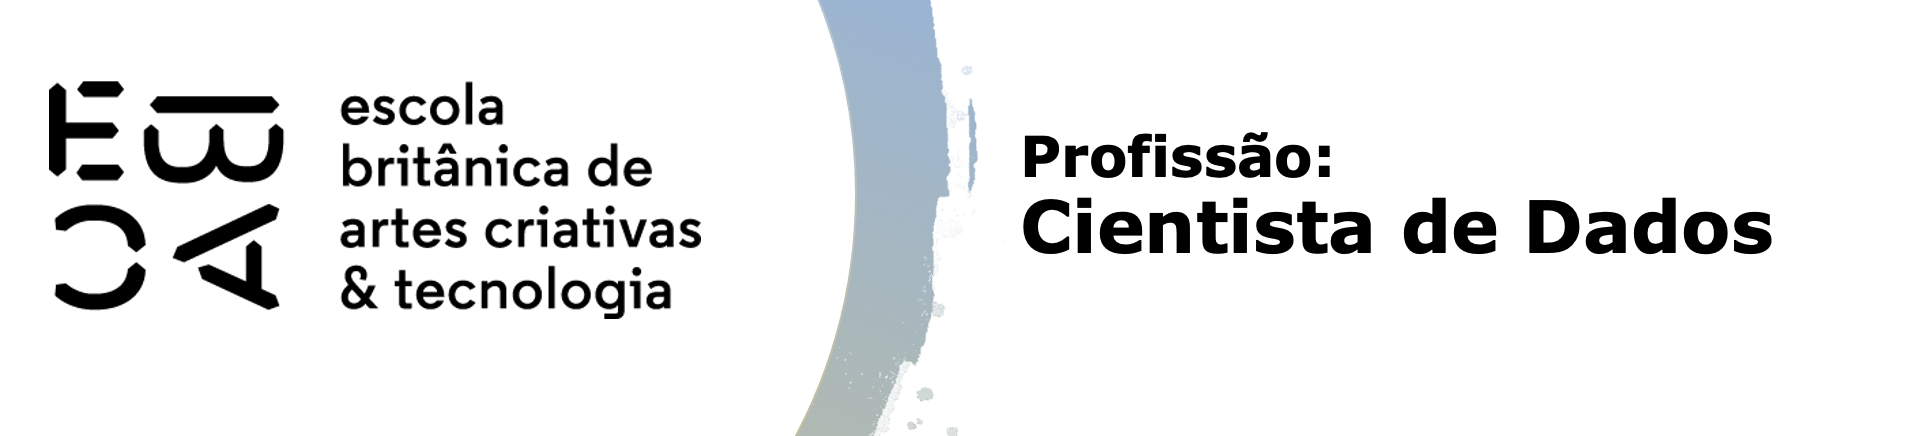

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [2]:
X_train = pd.read_csv('./input/X_train.csv').drop('Unnamed: 0', axis=1)
X_test = pd.read_csv('./input/X_test.csv').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('./input/y_train.txt', header=None)
y_test = pd.read_csv('./input/y_test.txt', header=None)

### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [3]:
# 3 melhores variáveis encontradas na tarefa anterior:
best_vals = ['tGravityAcc-min()-X', 'fBodyAcc-mad()-X', 'tGravityAcc-mean()-Y']

In [4]:
%%time
clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=27)
path = clf.cost_complexity_pruning_path(X_train[best_vals], y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

CPU times: total: 78.1 ms
Wall time: 49 ms


In [5]:
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [6]:
%%time
param_grid = {
    "ccp_alpha":ccp_alphas[::10]
}

grid = GridSearchCV(estimator = clf, param_grid=param_grid, cv=10, verbose=100)
grid.fit(X_train[best_vals], y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits
[CV 1/10; 1/11] START ccp_alpha=0.0.............................................
[CV 1/10; 1/11] END ..............ccp_alpha=0.0;, score=0.719 total time=   0.0s
[CV 2/10; 1/11] START ccp_alpha=0.0.............................................
[CV 2/10; 1/11] END ..............ccp_alpha=0.0;, score=0.738 total time=   0.0s
[CV 3/10; 1/11] START ccp_alpha=0.0.............................................
[CV 3/10; 1/11] END ..............ccp_alpha=0.0;, score=0.800 total time=   0.0s
[CV 4/10; 1/11] START ccp_alpha=0.0.............................................
[CV 4/10; 1/11] END ..............ccp_alpha=0.0;, score=0.724 total time=   0.0s
[CV 5/10; 1/11] START ccp_alpha=0.0.............................................
[CV 5/10; 1/11] END ..............ccp_alpha=0.0;, score=0.770 total time=   0.0s
[CV 6/10; 1/11] START ccp_alpha=0.0.............................................
[CV 6/10; 1/11] END ..............ccp_alpha=0.

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(min_samples_leaf=20,
                                              random_state=27),
             param_grid={'ccp_alpha': array([0.00000000e+00, 1.04385454e-05, 3.95898722e-05, 9.47627043e-05,
       2.28782031e-04, 3.76274354e-04, 4.89346705e-04, 7.85957745e-04,
       1.20002375e-03, 2.18481278e-03, 7.07801537e-03])},
             verbose=100)

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [7]:
melhor_ccp = grid.best_params_['ccp_alpha']
melhor_ccp

0.0070780153685231426

In [8]:
clf = DecisionTreeClassifier(random_state=27, ccp_alpha=melhor_ccp).fit(X_train[best_vals], y_train)

In [9]:
print(f'Acurácia: {clf.score(X_test[best_vals], y_test) * 100:.2f}%')

Acurácia: 73.80%


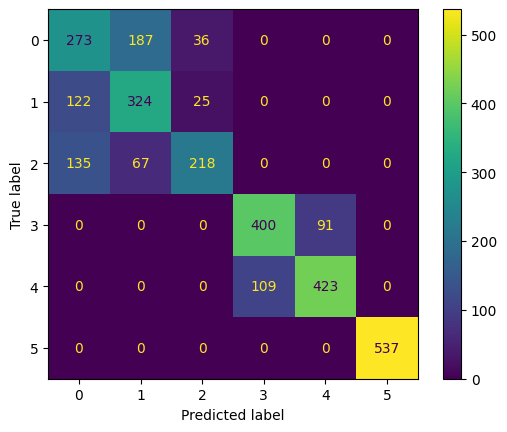

In [10]:
y_pred = clf.predict(X_test[best_vals])
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm).plot()
plt.show()

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [11]:
y_class2 = y_train==2

In [12]:
clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=27).fit(X_train, y_class2)

In [13]:
melhores_vals_class2 = [_ for _ in
     pd.DataFrame({'variavel':X_train.columns,
                   'importancia':clf.feature_importances_}
                 )
                 .sort_values('importancia',
                              ascending=False
                             )
                             .head(3).variavel
    ]
melhores_vals_class2

['tGravityAcc-arCoeff()-Z,1',
 'fBodyAcc-bandsEnergy()-1,8.2',
 'fBodyGyro-std()-X']

In [15]:
# Juntando as 3 melhores da classe 2 com as 3 da tarefa anterior
melhores_vals_class2 = list(set(best_vals + melhores_vals_class2))
melhores_vals_class2

['tGravityAcc-arCoeff()-Z,1',
 'fBodyGyro-std()-X',
 'fBodyAcc-mad()-X',
 'tGravityAcc-mean()-Y',
 'fBodyAcc-bandsEnergy()-1,8.2',
 'tGravityAcc-min()-X']

In [16]:
clf = DecisionTreeClassifier(random_state=27).fit(X_train[best_vals], y_train)

In [17]:
print(f'Acurácia: {clf.score(X_test[best_vals], y_test) * 100:.2f}%')

Acurácia: 71.94%


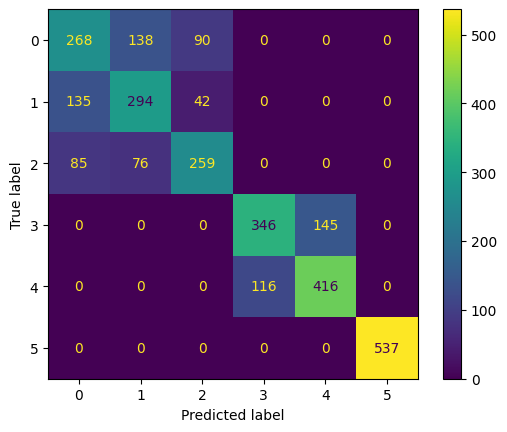

In [18]:
y_pred = clf.predict(X_test[best_vals])
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm).plot()
plt.show()

- ### Tentando melhorar o score achando 3 melhores variaveis para cada classe

In [19]:
tmp_best_vals = []+best_vals

In [20]:
for x in range(1,7):
    clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=27).fit(X_train, y_train == x)
    best_3_vals = [_ for _ in
     pd.DataFrame({'variavel':X_train.columns,
                   'importancia':clf.feature_importances_}
                 )
                 .sort_values('importancia',
                              ascending=False
                             )
                             .head(3).variavel
    ]
    tmp_best_vals += best_3_vals
    print(f'3 melhores variaveis para a classe {x}: {best_3_vals}')

3 melhores variaveis para a classe 1: ['tBodyGyroJerk-mad()-X', 'fBodyAccMag-std()', 'tGravityAcc-arCoeff()-X,1']
3 melhores variaveis para a classe 2: ['tGravityAcc-arCoeff()-Z,1', 'fBodyAcc-bandsEnergy()-1,8.2', 'fBodyGyro-std()-X']
3 melhores variaveis para a classe 3: ['tBodyAcc-max()-X', 'tBodyGyro-correlation()-Y,Z', 'fBodyAccMag-mad()']
3 melhores variaveis para a classe 4: ['tGravityAcc-min()-X', 'angle(Y,gravityMean)', 'fBodyGyro-std()-X']
3 melhores variaveis para a classe 5: ['angle(Y,gravityMean)', 'fBodyAcc-skewness()-X', 'fBodyAccJerk-bandsEnergy()-9,16.2']
3 melhores variaveis para a classe 6: ['tGravityAcc-min()-X', 'fBodyAccJerk-skewness()-Y', 'fBodyAccJerk-maxInds-Z']


In [21]:
# garantinho que não tenha strings duplicadas
tmp_best_vals = list(set(tmp_best_vals))
tmp_best_vals

['tGravityAcc-arCoeff()-Z,1',
 'fBodyAccMag-std()',
 'angle(Y,gravityMean)',
 'fBodyGyro-std()-X',
 'tBodyGyroJerk-mad()-X',
 'fBodyAcc-mad()-X',
 'fBodyAccJerk-bandsEnergy()-9,16.2',
 'fBodyAccJerk-maxInds-Z',
 'tGravityAcc-mean()-Y',
 'tBodyGyro-correlation()-Y,Z',
 'fBodyAccJerk-skewness()-Y',
 'fBodyAcc-bandsEnergy()-1,8.2',
 'tBodyAcc-max()-X',
 'tGravityAcc-min()-X',
 'tGravityAcc-arCoeff()-X,1',
 'fBodyAccMag-mad()',
 'fBodyAcc-skewness()-X']

In [22]:
%%time
# Achando novo ccp_alpha em cima das variáveis encontradas
clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=27)
path = clf.cost_complexity_pruning_path(X_train[tmp_best_vals], y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

CPU times: total: 297 ms
Wall time: 300 ms


In [23]:
ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

In [24]:
%%time
param_grid = {
    "ccp_alpha":ccp_alphas[::10]
}

grid = GridSearchCV(estimator = clf, param_grid=param_grid, cv=10, verbose=100)
grid.fit(X_train[tmp_best_vals], y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START ccp_alpha=0.0..............................................
[CV 1/10; 1/8] END ...............ccp_alpha=0.0;, score=0.876 total time=   0.1s
[CV 2/10; 1/8] START ccp_alpha=0.0..............................................
[CV 2/10; 1/8] END ...............ccp_alpha=0.0;, score=0.810 total time=   0.1s
[CV 3/10; 1/8] START ccp_alpha=0.0..............................................
[CV 3/10; 1/8] END ...............ccp_alpha=0.0;, score=0.907 total time=   0.1s
[CV 4/10; 1/8] START ccp_alpha=0.0..............................................
[CV 4/10; 1/8] END ...............ccp_alpha=0.0;, score=0.811 total time=   0.1s
[CV 5/10; 1/8] START ccp_alpha=0.0..............................................
[CV 5/10; 1/8] END ...............ccp_alpha=0.0;, score=0.856 total time=   0.1s
[CV 6/10; 1/8] START ccp_alpha=0.0..............................................
[CV 6/10; 1/8] END ...............ccp_alpha=0.0;

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(min_samples_leaf=20,
                                              random_state=27),
             param_grid={'ccp_alpha': array([0.00000000e+00, 1.32086271e-05, 1.06409854e-04, 3.01330878e-04,
       8.99148556e-04, 1.43136840e-03, 3.28779345e-03, 7.75235529e-02])},
             verbose=100)

In [25]:
melhor_ccp = grid.best_params_['ccp_alpha']
melhor_ccp

0.003287793445440947

In [26]:
clf = DecisionTreeClassifier(random_state=27, ccp_alpha=melhor_ccp).fit(X_train[tmp_best_vals], y_train)

In [27]:
print(f'Acurácia: {clf.score(X_test[tmp_best_vals], y_test) * 100:.2f}%')

Acurácia: 84.87%


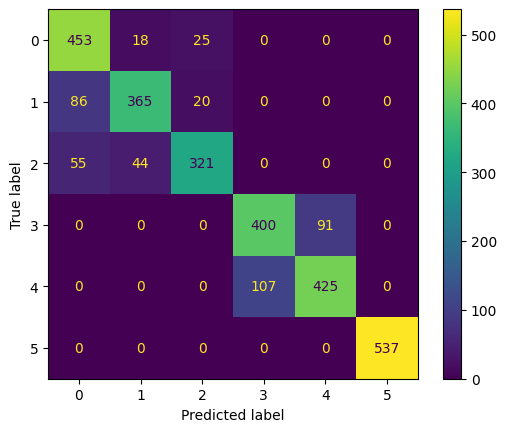

In [28]:
y_pred = clf.predict(X_test[tmp_best_vals])
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm).plot()
plt.show()